In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2

In [ ]:
path = "DB"
print(os.listdir(path))

image_paths = list(paths.list_images(path))
print(len(image_paths))

['no', 'yes', '.ipynb_checkpoints']
253


In [ ]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

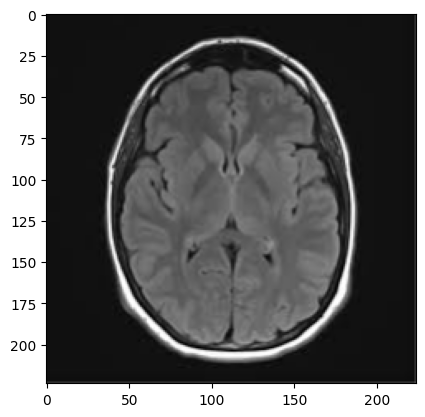

In [ ]:
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

In [ ]:
images = np.array(images) / 255.0
labels = np.array(labels)

In [ ]:
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

print(labels[0])

[1. 0.]


In [ ]:
(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

In [ ]:
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [ ]:
base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="sigmoid")(base_output)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
image = tf.random.normal((1, 224, 224, 3))
print(model.predict(image))

1/1 [==============================] - 1s 936ms/step
[[0.59380555 0.5230199 ]]


In [ ]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

In [ ]:
model.fit(train_generator.flow(train_X, train_Y, batch_size= batch_size),
                              steps_per_epoch= train_steps,
                              validation_data = (test_X, test_Y),
                              validation_steps= validation_steps,
                              epochs= epochs)

Epoch 1/10
28/28 [==============================] - 137s 5s/step - loss: 0.7198 - accuracy: 0.5616 - val_loss: 0.6280 - val_accuracy: 0.6154
Epoch 2/10
28/28 [==============================] - 135s 5s/step - loss: 0.6599 - accuracy: 0.6164 - val_loss: 0.6063 - val_accuracy: 0.6154
Epoch 3/10
28/28 [==============================] - 136s 5s/step - loss: 0.6152 - accuracy: 0.6712 - val_loss: 0.5858 - val_accuracy: 0.8462
Epoch 4/10
28/28 [==============================] - 135s 5s/step - loss: 0.5981 - accuracy: 0.7215 - val_loss: 0.5552 - val_accuracy: 0.7692
Epoch 5/10
28/28 [==============================] - 135s 5s/step - loss: 0.5577 - accuracy: 0.7397 - val_loss: 0.5340 - val_accuracy: 0.7692
Epoch 6/10
28/28 [==============================] - 136s 5s/step - loss: 0.5606 - accuracy: 0.7489 - val_loss: 0.5181 - val_accuracy: 0.7692
Epoch 7/10
28/28 [==============================] - 135s 5s/step - loss: 0.5345 - accuracy: 0.7808 - val_loss: 0.5012 - val_accuracy: 0.7692
Epoch 8/10
28

In [ ]:
model.save("tumortest9_10epoch.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
from IPython.display import display, Image
import io  # Add this line
import ipywidgets as widgets
import numpy as np
from PIL import Image as PILImage
from keras.models import load_model

model = load_model('tumortest9_10epoch.h5')
classes = {
    0: 'Normal',
    1: 'Tumeur'
}

def classify(file_content):
    image = PILImage.open(io.BytesIO(file_content)).convert('RGB')
    image = image.resize((224, 224))
    image = np.expand_dims(image, axis=0)
    image = np.array(image)
    image = image / 255
    pred = model.predict(image)
    pred = np.argmax(pred, axis=1)
    print(pred)
    if pred > 0.9:
        pred = 1
    else:
        pred = 0
    sign = classes[pred]
    print(sign)

upload_button = widgets.FileUpload()
display(upload_button)

def on_upload_button_change(change):
    for filename, file_content in upload_button.value.items():
        img = Image(data=file_content['content'], format='png')
        display(img)
        classify(file_content['content'])

upload_button.observe(on_upload_button_change, names='_counter')


FileUpload(value={}, description='Upload')